In [1]:
from __future__ import print_function

import argparse
import pickle
import numpy as np
from sklearn import cluster, metrics

import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import keras
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from time import time
from scipy.stats import mode


Using TensorFlow backend.


In [2]:
start = time()
NUM_CLASSES, IMG_ROWS, IMG_COLS = 10, 28, 28
new_classes = [5,6,7,8,9]
old_classes = list(x for x in range(NUM_CLASSES) if x not in new_classes)

In [3]:
def get_data_by_label(data, target, labels=range(NUM_CLASSES)):
    """
    Extract data according to a list of labels
    data = x_train
    target = y_train (not one_hot)
    labels = [0, 1]
    """
    if type(labels) is int:
        labels = [labels]
    position = []
    for label in labels:
        position_part = np.where(target == label)[0] # That is because np.where returns a tuple
        position.extend(position_part)
    data_part = data[position]
    target_part = target[position]
    return data_part, target_part

In [4]:
def cluster_accuracy(y_true, y_predict):
    # we assume the cluster labels are determined by its majority class inside
    # print(y_true.shape)
    # print(y_predict.shape)
    pseudo_classes = np.unique(y_predict)
    y_relabel = np.zeros_like(y_predict)
    for p_class in pseudo_classes:
        true_corresponding_classes = y_true[y_predict==p_class]
        majority = mode(true_corresponding_classes)[0]
        y_relabel[y_predict==p_class] = majority
    acc = np.sum(y_relabel == y_true) / float(len(y_true))
    return acc

In [5]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))
print(x_all.shape,y_all.shape)
x_all = x_all.astype(float)
sample_size = len(x_all)


x_all_2D = x_all.reshape(sample_size,-1)
print('The sample size after reshaping is:',x_all_2D.shape)
print('********Scaling dataset***********') 
scaler = StandardScaler()
scaler.fit(x_all_2D)
x_all_2D = scaler.transform(x_all_2D)


(70000, 28, 28) (70000,)
The sample size after reshaping is: (70000, 784)
********Scaling dataset***********


In [6]:
x_old, y_old = get_data_by_label(x_all_2D,y_all,labels=old_classes)
x_new, y_new = get_data_by_label(x_all_2D,y_all,labels=new_classes)

********PCA Part***********
saved variance 0.935062101566123


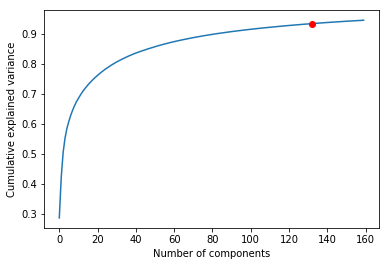

In [7]:
print('********PCA Part***********')
totoal_number_of_features = 28*28
number_of_feature_framewrok = 128+32

pca = PCA(n_components=number_of_feature_framewrok)
pca.fit(x_old)
Culumative_EVR = np.cumsum(pca.explained_variance_ratio_)
plt.plot(Culumative_EVR)
plt.plot(132, Culumative_EVR[132], 'ro')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
print("saved variance",Culumative_EVR[132])

In [8]:
x_old_pca = pca.transform(x_old)
x_new_pca = pca.transform(x_new)

In [9]:
kmeans = cluster.KMeans(n_clusters=5, random_state=0).fit(x_new_pca)
label_cluster = kmeans.labels_
y_true = y_new
y_cluster = label_cluster

acc = cluster_accuracy(y_true, y_cluster)
ARI = metrics.adjusted_rand_score(y_true, y_cluster)
NMI = metrics.adjusted_mutual_info_score(y_true, y_cluster)
HS = metrics.homogeneity_score(y_true, y_cluster)
VM = metrics.v_measure_score(y_true, y_cluster)

print(acc,ARI,NMI,HS,VM)
end = time()
print("Executaion time",end-start)

0.6958571428571428 0.42003797109198543 0.4793181912984282 0.47939215293940357 0.4873601823958241
Executaion time 53.6119761467
